In [1]:
import numpy as np
import pandas as pd
import torch
import os
import time_series_explainer.ts_explainer as ts_explainer
import matplotlib.pyplot as plt
import lightgbm

In [2]:
# Import sklearn models and tools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, DotProduct

In [3]:
DIR = "./ucsd"

giga_batch = np.load(os.path.join(DIR, "giga_batch.npy"))
y_giga_batch = np.load(os.path.join(DIR, "giga_batch_y.npy"))
columns_giga_batch = np.load(os.path.join(DIR, "giga_batch_columns_name.npy"), allow_pickle=True)

In [4]:
class TimeSeriesModel:
    def __init__(self, model):
        self.model = model

    def fit(self, X: np.array, y: np.array):
        self.size = min([arr.shape[1] for arr in X])

        self.model.fit([arr[:, : self.size].ravel() for arr in X], y)

    def predict(self, X: np.array):
        if isinstance(X, list) or len(X.shape) == 3:
            return self.model.predict([arr[:, : self.size].ravel() for arr in X])
        else:
            return self.model.predict(X.ravel()[None, :])

    def predict_proba(self, X):
        if isinstance(X, list) or len(X.shape) == 3:
            return self.model.predict_proba([arr[:, : self.size].ravel() for arr in X])
        else:
            return self.model.predict_proba(X.ravel()[None, :])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(giga_batch, y_giga_batch, test_size=0.2, random_state=420)

In [6]:
X_train.shape, X_test.shape

((2944, 6, 1000), (736, 6, 1000))

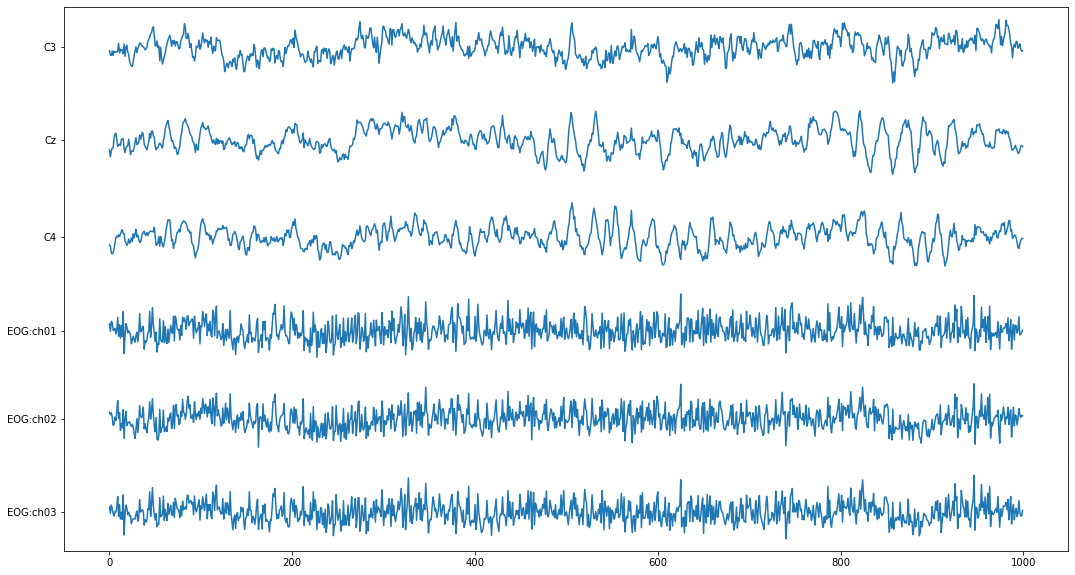

In [7]:
fig, _ = ts_explainer.plot_eeg(X_train[0], features_name=columns_giga_batch, figsize=(18, 10))
fig.savefig('./reports/diploma/figures/motor_ts.png', bbox_inches='tight', pad_inches=0.2)
plt.show()

In [8]:
model = TimeSeriesModel(LogisticRegression(C=0.000006, max_iter=100))
model.fit(X_train, y_train)
f1_score(y_test, model.predict(X_test)), accuracy_score(y_test, model.predict(X_test))

(0.7287899860917941, 0.7350543478260869)

In [9]:
model = TimeSeriesModel(lightgbm.LGBMClassifier(learning_rate=0.05, n_estimators=300))
model.fit(X_train, y_train)
f1_score(y_test, model.predict(X_test)), accuracy_score(y_test, model.predict(X_test))

(0.7262569832402236, 0.7336956521739131)

In [12]:
np.argmax(model.predict_proba(X_test), 0)

array([427, 155])

In [13]:
 model.predict_proba(X_test[672]),  model.predict_proba(X_test[294])

(array([[9.99785017e-01, 2.14982539e-04]]), array([[0.00138226, 0.99861774]]))

In [14]:
idx = 294 # explained instance
num_features = 40 # how many feature contained in explanation
num_slices = 20 # split time series
inst = X_test[idx]
inst_label = y_test[idx]
inst.shape, inst_label

((6, 1000), 1)

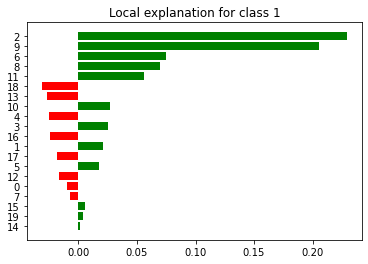

In [15]:
#explainer = ts_explainer.LimeTimeSeriesExplainer(model.predict_proba, metric="jaccard", replacement_method="random")
explainer = ts_explainer.ShapTimeSeriesExplainer(model.predict_proba, X_test, replacement_method="dataset_mean")
exp = explainer.explain_instance(inst, 
                                 labels=[0, 1], # для каких классов будет проводиться оценка "важности" 
                                 num_features=num_features, 
                                 num_samples=10000, 
                                 num_slices=num_slices,
                                )
exp.as_pyplot_figure(label=ins
                     t_label)
pass

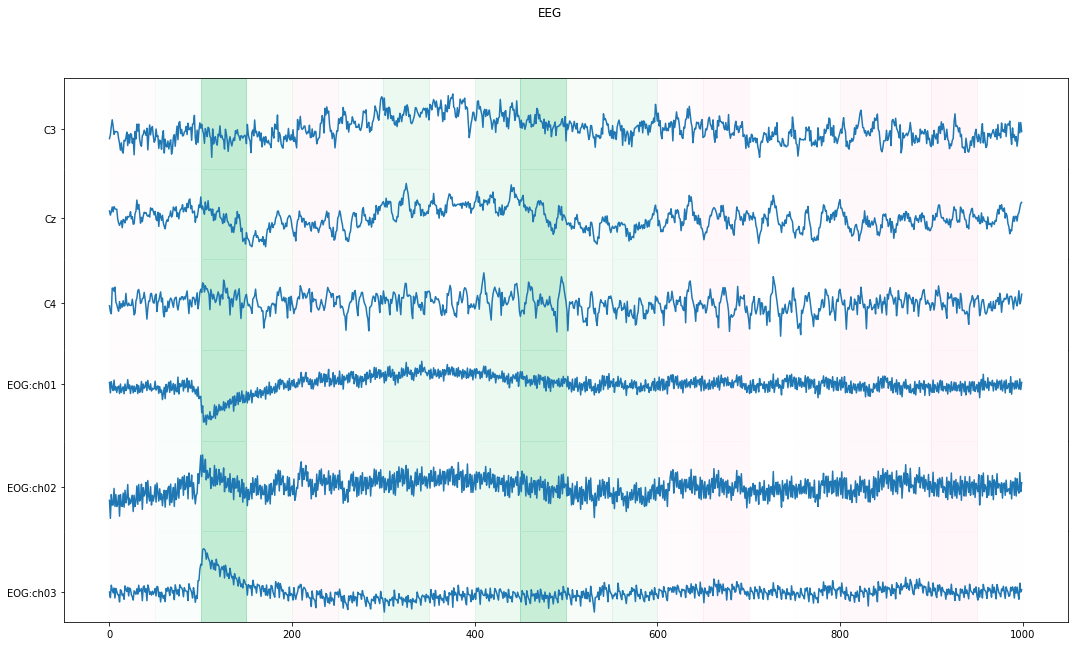

In [16]:
explanations = exp.as_list(label=inst_label)

denom = np.array([abs(x[1]) for x in explanations]).sum()
# привожу объяснения к отрезку [0, 1] (их модули), чтобы использовать их как alpha канал
explanations = [(x[0], x[1]/denom) for x in explanations]
fig, _ = ts_explainer.plot_eeg(inst,
                      explanations,
                      num_slices,
                      title="EEG",
                      features_name=columns_giga_batch, 
                      figsize=(18, 10),
                      positive_color="#13B755",
                      negative_color="#ff0d57")
#fig.savefig('./reports/diploma/figures/motor_ts_672_label_0.png', bbox_inches='tight', pad_inches=0.2)
plt.show()

In [17]:
functor = lambda num_slices: explainer.explain_instance(
                                inst, 
                                labels=[0,1],
                                num_features=num_slices, 
                                num_samples=5000, 
                                num_slices=num_slices
                                )
cumulative_explanation = ts_explainer.cumulative_explanation(inst, 
                                                             inst_label, 
                                                             functor, 
                                                             np.arange(5, 100, 10))

/Users/tytskiy/Education/Bachelor-s-Thesis/time_series_explainer/ts_explainer.py:45: UserWarning: Generated with gen_with_replacement = True because num_slices >= 63
  warnings.warn("Generated with gen_with_replacement = True because num_slices >= 63")
/Users/tytskiy/Education/Bachelor-s-Thesis/time_series_explainer/ts_explainer.py:45: UserWarning: Generated with gen_with_replacement = True because num_slices >= 63
  warnings.warn("Generated with gen_with_replacement = True because num_slices >= 63")
/Users/tytskiy/Education/Bachelor-s-Thesis/time_series_explainer/ts_explainer.py:45: UserWarning: Generated with gen_with_replacement = True because num_slices >= 63
  warnings.warn("Generated with gen_with_replacement = True because num_slices >= 63")
/Users/tytskiy/Education/Bachelor-s-Thesis/time_series_explainer/ts_explainer.py:45: UserWarning: Generated with gen_with_replacement = True because num_slices >= 63
  warnings.warn("Generated with gen_with_replacement = True because num_sli

In [18]:
explanations = cumulative_explanation[0]
denom = np.array([x[1] for x in explanations]).sum()
explanations = [(x[0], 10 * x[1]/denom) for x in explanations]

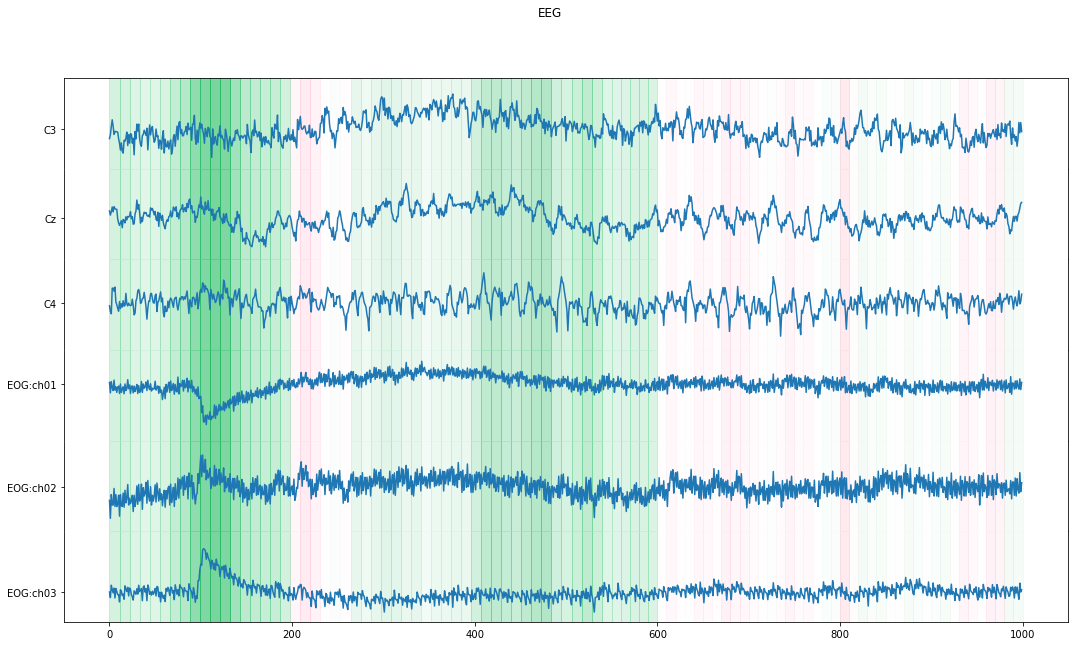

In [19]:
fig, _ = ts_explainer.plot_eeg(inst,
                      explanations,
                      max(np.arange(5, 100, 10)),
                      title="EEG",
                      features_name=columns_giga_batch, 
                      figsize=(18, 10),
                      positive_color="#13B755",
                      negative_color="#ff0d57")
fig.savefig('./reports/diploma/figures/motor_ts_294_label_1_cumulative.png', bbox_inches='tight', pad_inches=0.2)
plt.show()

In [80]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesDataset(Dataset):
    def __init__(self, giga_batch, labels=None, train=True, transform=None):
        if train:
            assert (giga_batch.shape[0] == labels.shape[0])
            self.labels = torch.tensor(labels)[:, None].float()
        self.giga_batch = torch.tensor(giga_batch).float().unsqueeze(1)
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        ts = self.giga_batch[idx]
        if self.transform:
            ts = self.transform(ts)
            
        if self.train:
            return ts, self.labels[idx]
        else:
            return ts

In [81]:
batch_size = 100
seq_len = X_train.shape[-1]
n_features = X_train.shape[1]
train_set = TimeSeriesDataset(X_train, labels=y_train, train=True, transform=None)
test_set = TimeSeriesDataset(X_test, labels=y_test, train=True, transform=None)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
seq_len, n_features

(1000, 6)

In [98]:
class CNN_TS(nn.Module):
    def __init__(self, seq_len, n_features, n_filters=(32, 64, 32), droprate=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, n_filters[0], kernel_size=(n_features, seq_len//10))
        self.conv2 = nn.Conv2d(n_filters[0], n_filters[1], kernel_size=(1, seq_len//(10*3)))
        self.pool = nn.MaxPool2d((1, 2))
        self.conv3 = nn.Conv2d(n_filters[1], n_filters[2], kernel_size=(1, seq_len//(10*3*3)))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(droprate)
        self.linear1 = nn.LazyLinear(100)
        self.linear2 = nn.LazyLinear(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x



In [99]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net = CNN_TS(seq_len=seq_len, n_features=n_features)
net = net.to(device)

cpu


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [100]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
for epoch in range(20):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        net.eval()
        data, y = test_set[:]
        pred = net(data)
        pred = pred > 0.5
        print(f'epoch: {epoch + 1}, f1: {f1_score(y, pred)}, acc: {accuracy_score(y, pred)}')

epoch: 1, f1: 0.31058823529411766, acc: 0.6019021739130435
epoch: 2, f1: 0.6020761245674741, acc: 0.6875
epoch: 3, f1: 0.5656934306569343, acc: 0.6766304347826086
epoch: 4, f1: 0.5242718446601942, acc: 0.6671195652173914
epoch: 5, f1: 0.5730337078651686, acc: 0.6902173913043478
epoch: 6, f1: 0.53125, acc: 0.6739130434782609
epoch: 7, f1: 0.6312292358803987, acc: 0.6983695652173914
epoch: 8, f1: 0.6500829187396352, acc: 0.7133152173913043
epoch: 9, f1: 0.6836248012718601, acc: 0.7296195652173914
epoch: 10, f1: 0.6883116883116883, acc: 0.7391304347826086
